# <strong>Метрики в задачах классификации</strong>







Сейчас мы рассмотрим метрики в задачах классификации. 

Для обучения возьмём уже существующий классификатор на основе метода стохастического градиентного спуска (SGD - Stohastic
Gradient Descent) класс SGDClassifier из библиотеки Scikit-Learn. 

Причина почему мы используем данный классификатор - его эффективность при обработке очень крупных наборов данных. 
Связано это в основном с тем, что SGD использует обучающие образцы один раз независимым образом.
Далее создадим экземпляр SGDClassifier и обучим его на целом, имеющемся у нас, обучающем наборе. (для примера будем использовать датасет MNIST)

Этот класс полагается на неупорядоченность во время обучения, что соответствует значению слова "стохастический".

*Стохастический - случайный, вероятностный, беспорядочный, непредсказуемый.*

На его примере мы рассмотрим матрицу неточностей, точность, полноту и другие метрики.

# <strong>Матрица неточностей</strong>

Пусть у нас есть 2 класса - класс A и класс B. (выберем два произвольных класса из датасета)

Мы решаем задачу классификации, попробуем разделить эти два класса.
Как оценить насколько хорошо работет наш классификатор?

Достаточно неплохой способ оценки эффективности классификатора предусматривает просмотр <i>матрицы неточностей</i> (<i>confusion matrix</i>).


<i>Матрица неточностей: на пересечении строк и столбцов показано, сколько раз модель отнесла элемент к классу.</i>


Чтобы понять суть матрицы неточностей, рассмотрим немного отстраненный пример. Сущесствуют четыре класса: *Elephant, Monkey, Fish, Lion." Рассмотрим матрицу, приведенную ниже. 

Объект класса *Monkey* был правильно отнесен классификатором к классу *Monkey* 53 раза (пересечение строки и столбца *Monkey*). В то время как элементы класса *Fish* были отнесены к классу *Monkey* 3 раза (пересечение столбца *Fish* и строки *Monkey*), а элементы класса *Monkey* были отнесены к классу *Fish* лишь 1 раз (пересечение столбца *Monkey* с строкой *Fish*).

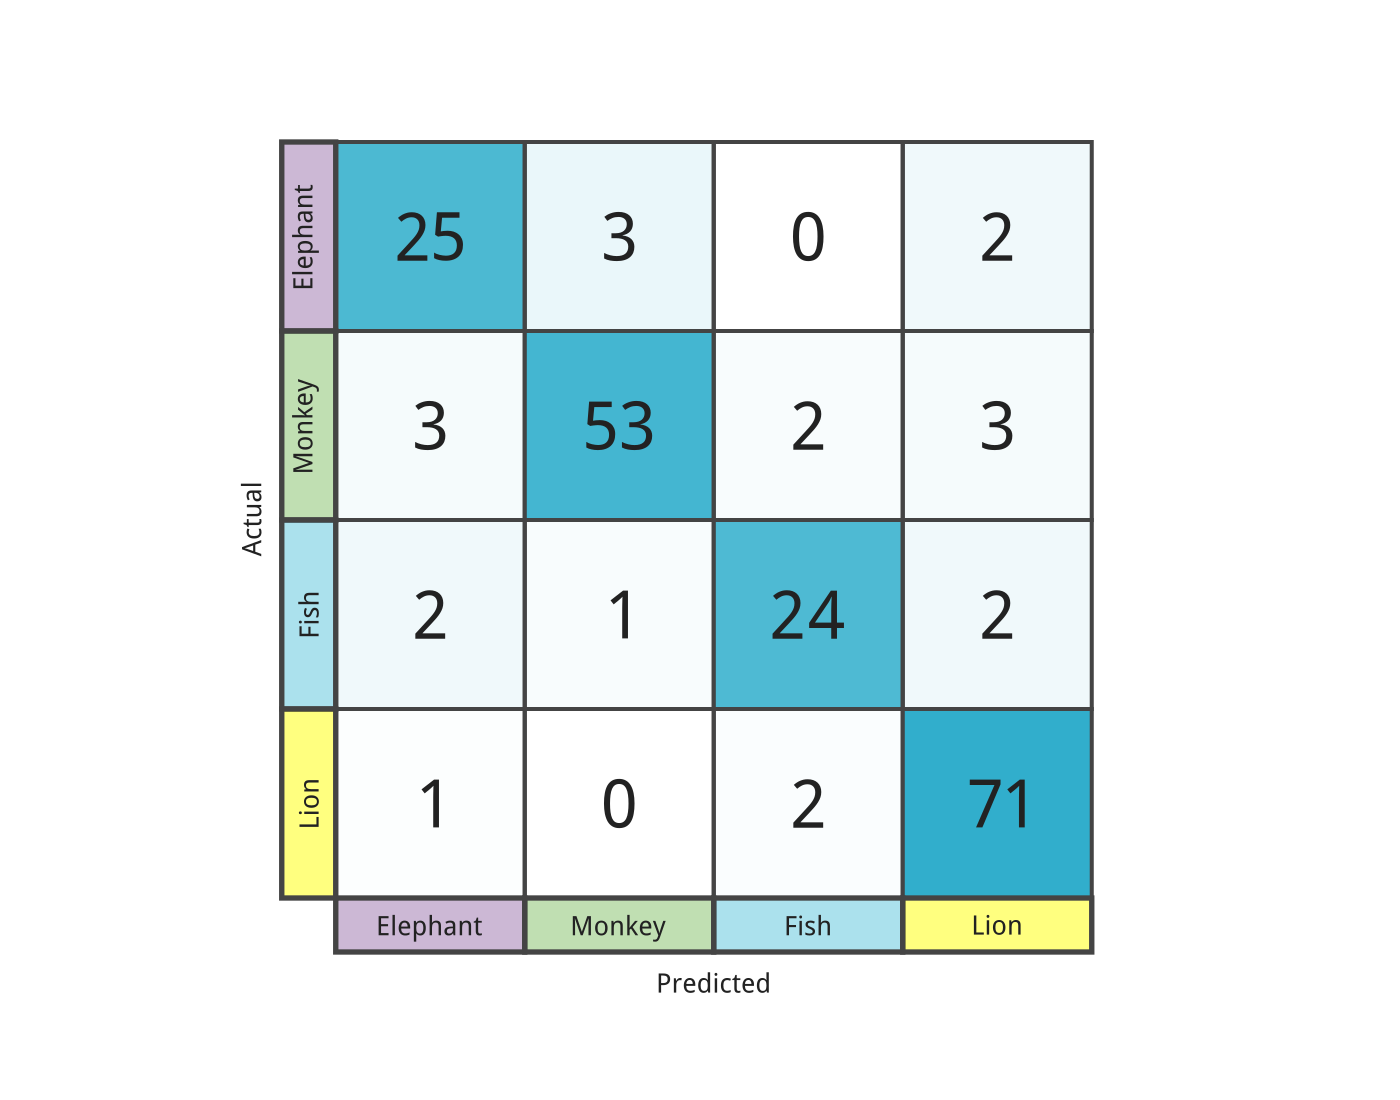


Мы рассмотрели достаточно наглядный пример, что представляет из себя матрица неточностей. Давайте рассчитаем ее самостоятельно на элементах датасета MNIST.

Чтобы рассчитать матрицу неточностей, нужно иметь какой-то набор прогноз. 

Датасет стоит разделить на тренировочный и тестовый наборы.(датасет MNIST уже разделён)
Можно выработать прогнозы на тестовом наборе и оценивать классификатор на тестовых данных, но давайте используем его в самом конце на готовом классификаторе, а оценку проведем на тренировочном. 

Используем функцию <i>cross_val_predict()</i>.

Дополнительно разделим тренировочный набор на К блоков.
Функция cross_val_predict() выполняет перекрестную проверку по К блокам и возвращает предсказания нашего классификатора, выработанные на каждом тренировочном блоке. 

В результате, мы получим прогноз для каждого образца, сделанный моделью, которая никогда не видела тестовые данные во время обучения, то есть, так называемый "<i>чистый</i>" прогноз.

Теперь мы можем получить матрицу неточностей, используя функцию conflusion_matrix(), передавая ей целевые классы y_train_3 (выберем тренировочный набор с цифрой 3) и спрогнозированные функцией cross_val_predict(), то есть, y_train_pred:

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3) # True для всех троек, False для всех остальных цифр. задача: распознать тройки
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) # классификатор на основе метода стохастического градиентного спуска (англ. Stochastic Gradient Descent SGD)
sgd_clf.fit(X_train, y_train_3) # обучаем классификатор распозновать тройки на целом обучающем наборе
# Для расчета матрицы ошибок сначала понадобится иметь набор прогнозов, чтобы их можно было сравнивать с фактическими целями
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
print(confusion_matrix(y_train_3, y_train_pred))
# что должно у вас получиться:
# array([[53477, 392],
#        [ 2113, 4018]])

ModuleNotFoundError: No module named 'sklearn'

Итак, поздравляю, мы получили матрицу неточностей!

В полученной матрице каждая строка представляет собой фактический класс, а каждый столбец спрогнозированный класс. 

В первой строке, которая учитывает изображения "не троек", в первом столбце можно увидеть число 53477, что соответствует числу **правильно классифицированных "не троек"** *(True Negative)*, а число, расположенное во втором столбце первой строки (392) соответствует числу **ошибочно классифицированных "не троек"**, то есть, цифр, отнесенных к классу "троек", но не являющихся "тройками" *(False Positive)*.

Вторая строка соответствует классу "троек", поэтому в первом столбце число 2113 означает число "троек", отнесенных по ошибке к другим классам (не троек) *(False Negative)*, а во втором столбце 4018 - число правильно классифицированных "троек" *(True Positive)*.

Для полной наглядности, реализуем "идальный" классификатор (у которого не будет неверно классифицированных элементов), работающий с точностью 100%. Как видно в выводе кода ниже - ненулевые значения находятся только на главной диагонали матрицы неточностей. 

В ней отсутствуют неправильно классифицированные цифры, поэтому на побочной диагонали вы можете видеть два "0".

In [3]:
#усечённая матрица неточностей
y_train_pred = y_train_3
print(confusion_matrix(y_train_3, y_train_pred))

[[53869     0]
 [    0  6131]]


Из матрицы неточностей можно получить много информации, однако, если вам не нужна лишняя информация, а требуется только один показатель (например, полнота),то можно использовать более сжатую метрику, одной из таких метрик является точность положительных классификаций (<i>precision</i>) то есть, точность классификатора. 

# <strong>Точность (precision)</strong>

Рассмотрим уравнение точности (precision):

### <strong>$precision =\frac{TP}{(TP+FP)}$</strong>

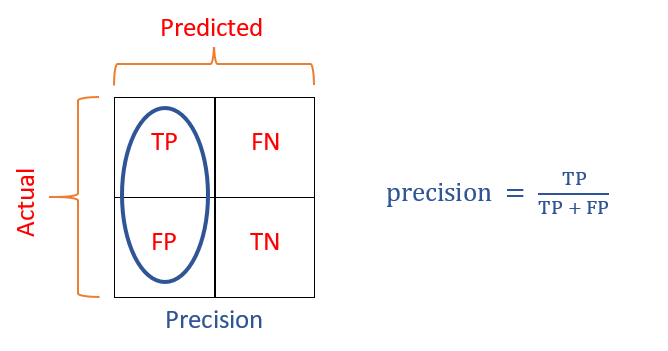

Где *TP - True Positive*, то есть, количество истинно положительных классификаций, а *FP - False Positive*, количество ложно положительных классификаций. 

Простым языком, TP - это количество объектов действительно принадлежащих к классу, к которому их отнесла модель, а FP - количество объектов, которых отнесли к данному классу по ошибке. Получаем, что точность - это "доля" объектов действительно принадлежащих данному классу относительно всех объектов которые система отнесла к этому классу (отношение количества правильно отнесенных к классу объектов к всем объектам, которые были отнесены к данному классу).

Однако, стоит отметить, что если будет правильно классифицирован лишь один объект и больше ничего не будет отнесено к данному классу, то точность в таком случае будет 100% (например, к классу "четверок" была отнесена лишь 1 четверка, и больше ничего, остальные цифры по ошибке беспорядочно распределились по остальным классам), поэтому вместе с точностью (precision) обычно используют ещё одну метрику - полноту (<i>recall</i>), к рассмотрению которой перейдем сейчас.

In [28]:
#рассчет точности precision для цифры 3 (по усечённой матрице неточностей, построенной выше)
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3) 
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_3) 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
print(precision_score(y_train_3, y_train_pred)) 

0.9111111111111111


# <strong>Полнота (recall)</strong>

### <strong>$recall =\frac{TP}{(TP+FN)}$</strong>


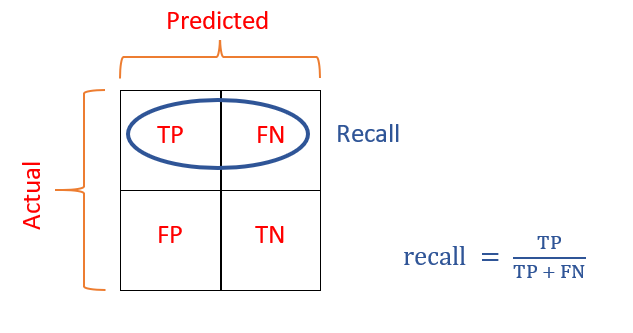

Вычисляется полнота следующим образом - количество истинно положительных классификаций (*TP - True Positive*), делится на сумму *TP + FN (False Negative - количество ложно отрицательных классификаций. То есть, количество не троек, по ошибке отнесенных классификатором к классу троек)*


In [5]:
# полнота
print(recall_score(y_train_3, y_train_pred)) 

0.655358016636764


Чтобы подвести некий промежуточный итог, отметим:

 Точность нашего классиикатора (precision) составляет 91%, это означает, что среди всех чисел, отнесенных к классу "троек" 91% - действительно тройки.
 
 А полнота (recall) только 65%, это значит, что доля найденных "троек" правильно отнесенных к классу "троек", по отношению ко всем "тройкам" в тестовом датасете составляет 0.65.




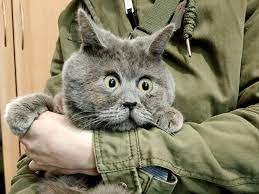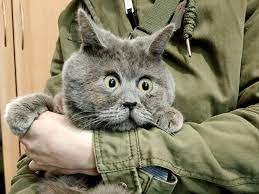


# <strong>Мера F1 (F1 score)</strong>


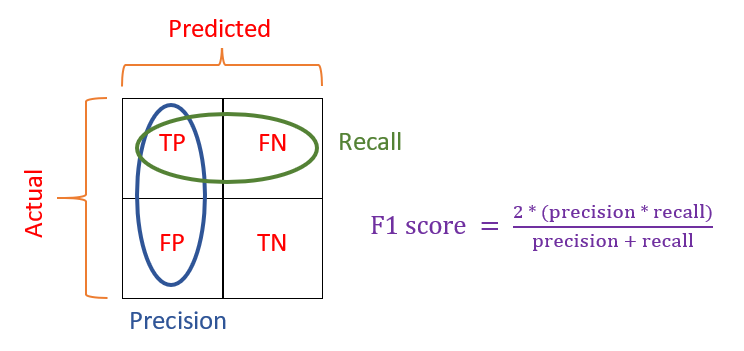

Если вам нужен простой способ сравнения двух классификаторов, можно объединить точность и полноту в одну метрику - F1 score, которая представляет собой среднее гармоническое точности и полноты (precision and recall). 

 Отличие F1 score от обычного среднего заключается в том, что простое среднее придает одинаковый вес всем значениям выборки, в то время как среднее гармоническое (F1 score) придает более низким значениям больший вес. 
 
 В результате показатель F1 score будет высоким тогда, когда высокими будут и точность и полнота. 
 
Расчёт данной метрики демонстрируется в коде ниже.

<i>Для вычисления F1 - меры достаточно просто вызвать функцию f1_score()</i>:
    

In [18]:
 # код для подсчета метрики F-мера:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3) 
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_3)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
print(f1_score(y_train_3, y_train_pred))

0.7623565126648326


Не всегда нужно учитывать и точность, и полноту одновременно.

Например, если вы создаете классификатор, который будет обрабатывать статьи, безопасные для прочтения бабушкам и дедушкам.

В таком случае,скорее всего лучше отдать предпочтение классификатору, который ошибочно отклоняет многие хорошие статьи (низкая полнота), но сохраняет только НА МИЛЛИОН ПРОЦЕНТОВ хорошие (высокая точность) во избежание побоища на лавочке у подъезда.
А не классификатору, который имеет более высокую полноту, но в то же время определяет статьи о росте цен на гречу в ближайшем супермаркете как хорошие (<i> для старшего поколения это настояший стресс, сразу давление поднимается</i>).

С другой стороны, если вы обучаете классификатор, который выявляет нежелательные для партии бабушек сети магазинов, которые меняют ценники на гречу, то скорее всего будет лучше, если ваш классификатор будет иметь лишь 30-ти процентную точность при 99-ти процентной полноте (<i>бабушки будут конечно получать ложные сигналы, но в незначительном количестве, но почти все злостные продавцы, заменяющие ценник на гречу, будут пойманы</i>).


К превеликому сожалению, невозможно получить и то и другое, так как увеличение точности снижает полноту и наоборот. 

Это называется соотношением точность/полнота (precision/recall trade-off)

# <strong>Соотношение точность/полнота</strong>

Чтобы иметь хоть какое-то представление о данном соотношении, давайте более подробно рассмотрим, как класс SGDClassifier принимает решения при классификации.

При принятии решения для каждого образца вычисляется сумма очков на основе функции решения (decision function). Если полученная сумма очков больше порогового значения, то элемент приписывается к положительному классу, иначе - к отрицательному.

На рисунке ниже цифры расположены от самой низкой суммы очков слева до самой высокой справа. Если предположить, что порог принятия решения *(decision threshold)* расположен на центральной вертикальной линии между двух троек, то справа от этого порога будут четыре истинно положительных классификации, которые на самом деле являются "тройками" и одну ложноположительную классификацию - "шестерку". При таком пороге точность составляет 80% (4 из 5 цифр действительно "тройки"), но из шести "троек" всего, при данном пороге, классификатор обнаруживает только четыре, следовательно, полнота составляет 67%. 

Из данной схемы становится понятно, что при увеличении порогового значения (смещения порога в правую строну), будет увеличиваться значение точности и уменьшаться значение полноты. При смещении порога в левую сторону (уменьшения порогового значения) будет увеличиваться значение полноты, но будет страдать точность.


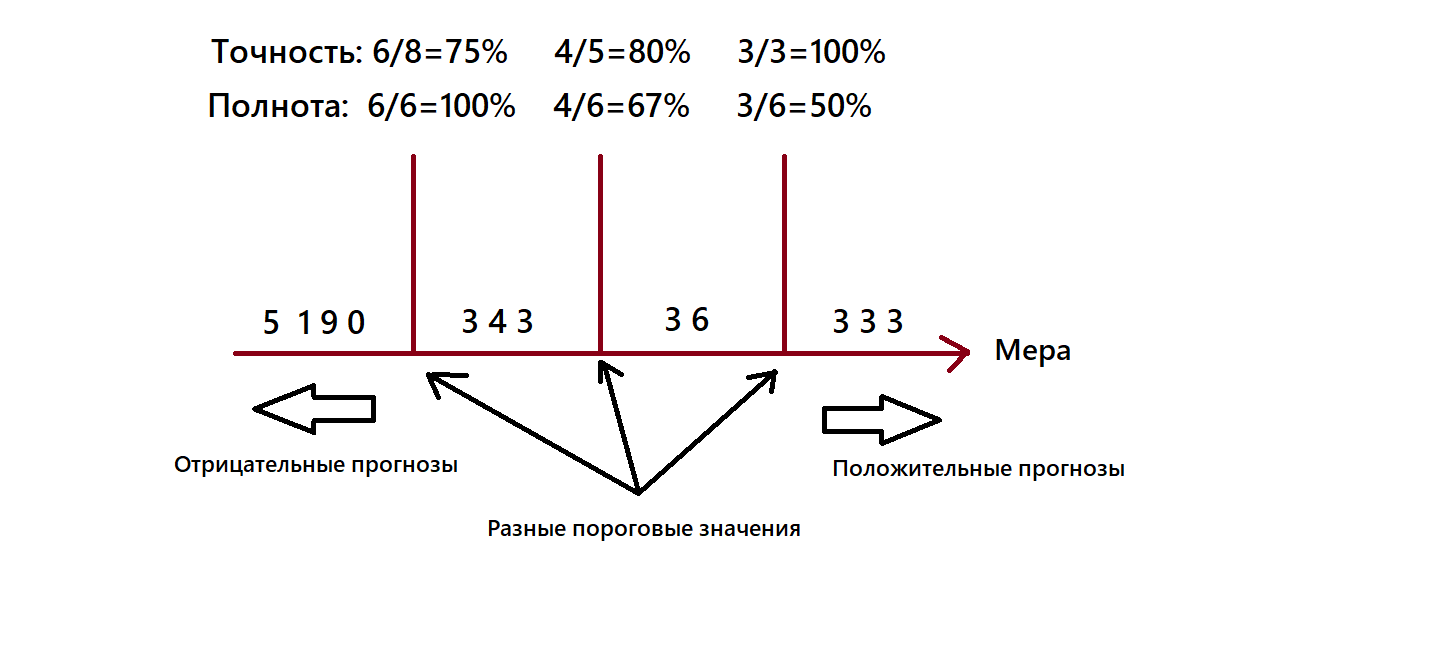



Чтобы получить суммы очков, используем функцию <b>precision_recall_curve()</b>, для вычисления точности и полноты всех возможных порогов. 

<b>Теперь порисуем:</b>

Cпособ для выбора хорошего соотношения точность/полнота включает в себя создание графика точности относительно полноты. 

По графику видно, что точность начинает резко падать при полноте около 70% - 80% (*т.к. при увеличение полноты приводит к снижению точности и наоборот*), поэтому, если важно хорошее соотношение, то следует выбирать отпимальное соотношение(как раз перед этим падением).

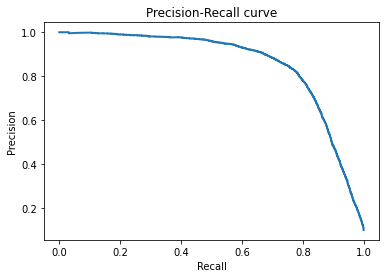

In [50]:
# Код отрисовки Precison-recall кривой
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3) 
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_3)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(recalls, precisions, linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.savefig("Precision_Recall_curve.png")
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Теперь нарисуем точность и полноту на одном графике:

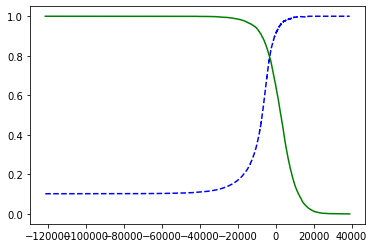

In [41]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3)
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_3)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_3, y_scores)
def hueta(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Точность")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Полнота")
hueta(precisions, recalls, thresholds)
plt.show()

Посмотрев на график, можно увидеть, что пересечение точности и полноты происходит при значении порогового значения около 0. Следовательно, если вы хотите получить точность 90%, тогда после того, как вы посмотрите на второй график, станет очевидно, что следует брать порог около -500. 

Чтобы обеспечить более высокую точность, можно отыскать меньший порог, используя <b>np.argmax()</b>. Она выведет первый индекс *максимального* значения, при котором первым значением будет <b>True</b>.


In [42]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
print(threshold_90_precision)

-411.4432659249586


Для выработки прогнозов на обучающем наборе, чтобы не вызывать метод <b>predict()</b>, можно использовать следующий код:


In [43]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(y_train_pred_90 )

[False False False ... False False False]


Для проверки точности и полноты таких прогнозов: 

In [44]:
from sklearn.metrics import  precision_score
precision_score(y_train_3, y_train_pred_90)


0.9000870700914236

In [45]:
from sklearn.metrics import recall_score
recall_score(y_train_3, y_train_pred_90)

0.6744413635622247

Замечательно! Мы сделали какую-то неработающую штуку с точностью 90%!

Для создания классификатора любой точности, которую вы сможете себе пожелать, нужно установить достаточно высокий порог и всё. Но помните, высокоточный классификатор не очень useful, если его полнота достаточно низкая.

# <strong>ROC кривая</strong>

Ещё одним распространенным инструментом, применяемым для бинарной классификации, является кривая рабочей характеристики (<i>receiver operating characteristic</i>) - <b>ROC</b>.

ROC-кривая - отношение доли истинно-положительных классификаций (True Positive Rate, также называется *чувствительностью* классификации) к доле ложно-положительных классификаций (False Positive Rate, величина (1 - FPR) называется *специфичностью* алгоритма классификации). 

Для отрисовки кривой <b>ROC</b>, необходимо определить <b>TPR</b> и <b>FPR</b>, описанные выше. 

Для этого используем функцию <b>roc_curve()</b>.

После определения нужных параметров, можем начертить график <b>FPR</b> по сравнению  с <b>TPR</b>:

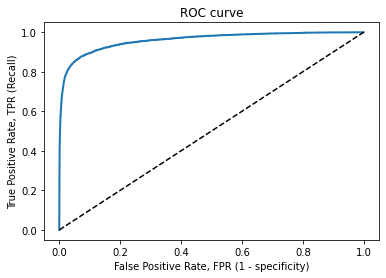

In [2]:
# Код отрисовки ROC-кривой
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import SGDClassifier
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train_3 = (y_train == 3)  
y_test_3 = (y_test == 3)
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_3) 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_3, cv=3, method="decision_function")
fpr, tpr, thresholds = roc_curve(y_train_3, y_scores)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate, FPR (1 - specificity)')
    plt.ylabel('True Positive Rate, TPR (Recall)')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
plot_roc_curve(fpr, tpr)
plt.show()

Итак, имеем нарисованную ROC кривую. 

Можно заметить, что чем выше полнота (recall), тем больше получается ложноположительных классифкаций (FPR). 

Пунктирная линия  - ROC кривая абсолютно случайного классификатора. Чем лучше классификатор, тем ближе к верхнему левому углу его прямая.

Из сказанного выше становится очевидно, что для оценки классификаторов, также как и для их сравнения, можно оценивать площадь под графиком кривой ROC.

Такой показатель есть и называется <b>AUC - area under the curve</b>. 

Чем лучше классификатор, тем ближе к 1 будет значение AUC. В то время как у абсолютно случайного классификатора, это значение будет 0,5. 

Рассчитаем площадь под графиком:

In [3]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_3, y_scores)

0.9599243001892759

Круто! Мы получили площадь под графиком!

Поскольку между кривыми ROC и кривой соотношения precision recall сходство неоспоримо, то возникнет вопрос: какую же метрику использовать?

Существует следующее правило: когда положительный класс редко встречается или более важны ложноположительные классификации, то следует отдавать предпочтение кривой PR. Иначе - кривой ROC. 

Например: на нашем графике ROC и при подсчете AUC мы получили неплохие значения лишь потому, что количество положительных классификаций (тройки в нашем случе) в несколько раз меньше, чем отрицательные классификации (не тройки).

В таком случае кривая PR в большей мере дает представление о том, как улучшить классификатор.

# <strong>RandomForestClassifier</strong>

Всё это время мы использовали классификатор SGDClassifier библиотеки Scikit Learn. 

Давайте попробуем обучить другой классификатор и увидеть его график ROC и площадь AUC. 

Опишем основные отличия RandomForestClassifier от SGDClassifier. 

В RandomForestClassifier нет метода decision_function(), но есть аналогичный метод - predict_proba().

Обычно у классификаторов есть какой-то из этих методов или сразу два. 

Метод predict_proba() возвращает массив (#содержащий строку на образец и столбец на класс) содержащий веростность того, что заданный образец принадлежит заданному классу.

Функция roc_curve() ожидает метки и показатели, но вместо этого ей можно передать вероятности классов. 

В примере мы применим вероятность положительного класса в качестве показателя и нарисуем график.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


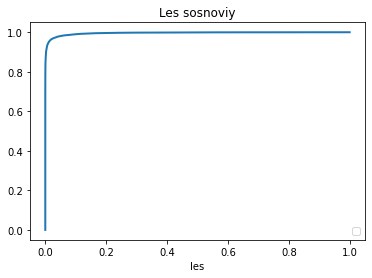

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
forest_clf = RandomForestClassifier(random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_3, cv =3, method = "predict_proba")
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_3, y_scores_forest)
#plt.plot(fpr, tpr, "b:", label = "SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2)
plt.legend(loc="lower right")
plt.xlabel('les')
plt.ylabel('')
plt.title('Les sosnoviy')
plt.savefig("Random_forest.png")
plt.show()

Сравнивая график ROC кривой двух классификаторов, можно заметить, что кривая ROC RandomForestClassifier намного ближе к левому верхнему углу, чем кривая ROC SGDClassifier. 

В таком случае показатель AUC тоже будет лучше. 

In [5]:
roc_auc_score(y_train_3, y_scores_forest)

0.995864544068936

Вы можете самостоятельно измерить показатели точности и полноты для фореста (второй классификатор, который не сгд) и сравнить их ~~так как я устал, сделайте что-нибудь сами емае~~.

Вы научились (хотелось бы верить) обучать двоичные классификаторы, выбирать подходящие метрики для оценки ваших классификаторов, узнали про перекрестную проверку и метрики. 


